In [1]:
import sys
sys.executable

'D:\\Anaconda3\\envs\\gpwork\\python.exe'

* Документация по [History Callback](https://keras.io/callbacks/#history) на сайте Keras.
* Страница [TensorBoard]()

# Подключение библиотек

In [33]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.keras.utils import to_categorical
from tensorflow.keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%pylab inline
%matplotlib inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# Подключения библиотеки для разделения данных

In [37]:
from sklearn.model_selection import train_test_split

# TensorBoard and CallBacks

In [41]:
tensorboard = TensorBoard(log_dir='tb_logs', histogram_freq=1, write_graph=True)
callback_list = [tensorboard]
print("TensorBoard and CallBacks init successful")

TensorBoard and CallBacks init successful


# Функция загрузки сигнала, Train и Test

In [6]:
def create_dataset(filepath):
    sgn = []
    lbl = []
    path = filepath + "/{}_data.txt"
    for i in range(0,10):
        data = np.loadtxt(path.format(i+1), dtype=np.float64)
        for j in range(np.shape(data)[0]):
            sgn.append(data[j, :])
            lbl.append(i)
    
    c = list(zip(sgn, lbl))
    shuffle(c)
    sgn, lbl = zip(*c)

    sgn = np.asarray(sgn, dtype=np.float64)
    lbl = np.asarray(lbl, dtype=np.int64)

    train_signals = sgn[0:int(0.6*len(sgn))]
    train_labels = lbl[0:int(0.6*len(lbl))]
    val_signals = sgn[int(0.6*len(sgn)):int(0.8*len(sgn))]
    val_labels = lbl[int(0.6*len(lbl)):int(0.8*len(lbl))]
    test_signals = sgn[int(0.8*len(sgn)):]
    test_labels = lbl[int(0.8*len(lbl)):]

    nrows, ncols = train_signals.shape
    train_signals = train_signals.reshape(nrows, ncols, 1)
    nrows, ncols = val_signals.shape
    val_signals = val_signals.reshape(nrows, ncols, 1)
    nrows, ncols = test_signals.shape
    test_signals = test_signals.reshape(nrows, ncols, 1)
    
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)

    return train_signals, train_labels, val_signals, val_labels, test_signals, test_labels

# Функция отображения метрик

In [7]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [8]:
test_samples = 158

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 8))
    for i, idx in enumerate(list(np.arange(0, test_samples, 22))):
        # display original
        ax = plt.subplot(4, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx], "r")
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)

# Load data

In [9]:
files_path = "C:/Users/leoska/data_emg/" #path to your directory with 10 data.txt files
train_signals, train_labels, val_signals, val_labels, test_signals, test_labels = create_dataset(files_path)

print("Load data successful")

Load data successful


# Init train and test data

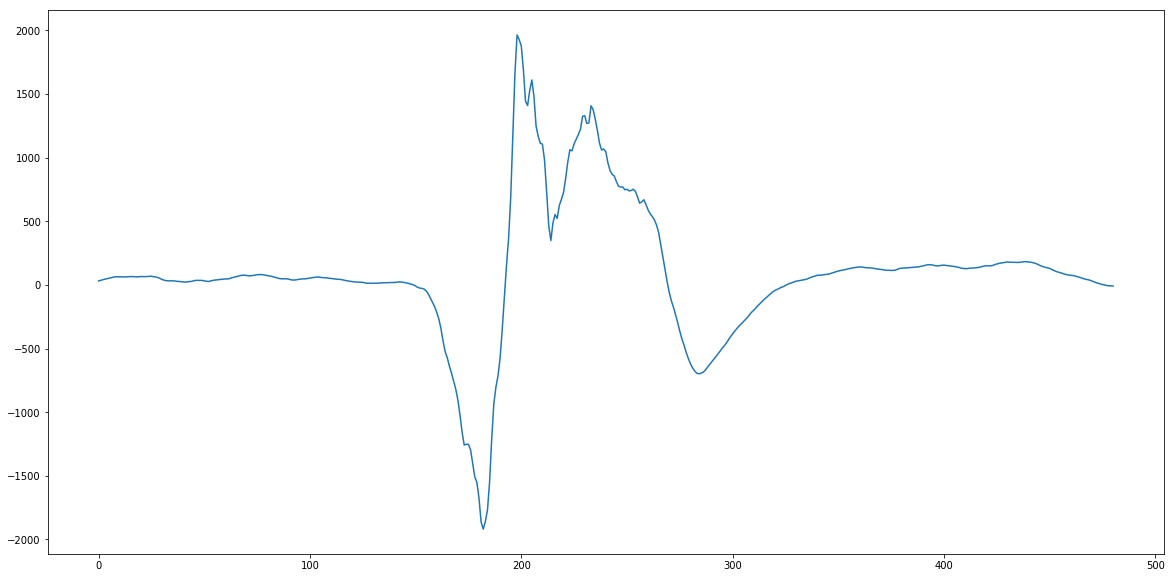

In [10]:
plt.figure(figsize=(20,10))
plt.plot(train_signals[2])
#plt.legend()

# Percentage of test data

In [ ]:
print("Percentage of test data: {}%".format((test_size / len(test_signals)) * 100))

In [11]:
print("Train signal shape: " + str(train_signals.shape))
print("Train labels shape: " + str(train_labels.shape))
print("Test signal shape: " + str(test_signals.shape))
print("Test labels shape: " + str(test_labels.shape))
print("Val signal shape: " + str(val_signals.shape))
print("Val labels shape: " + str(val_labels.shape))

Train signal shape: (474, 481, 1)
Train labels shape: (474, 10)
Test signal shape: (158, 481, 1)
Test labels shape: (158, 10)
Val signal shape: (158, 481, 1)
Val labels shape: (158, 10)


(474, 481, 1)
(158, 481, 1)
(158, 481, 1)
(474, 481)
(158, 481)
(158, 481)


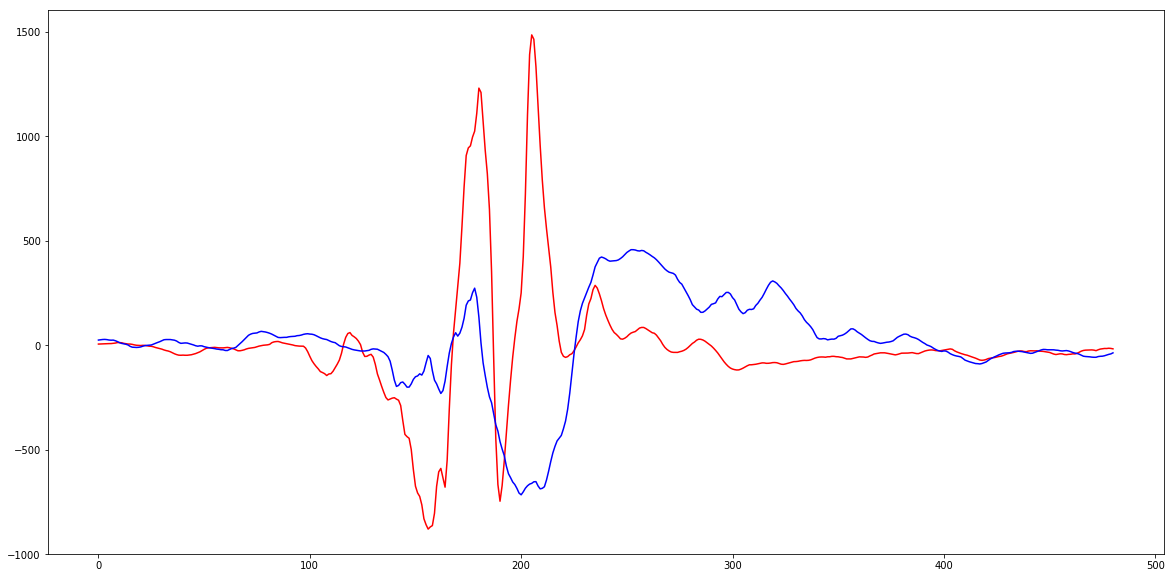

In [12]:
print(train_signals.shape)
print(test_signals.shape)
print(val_signals.shape)

x_train_simple = np.asarray(train_signals).reshape((len(train_signals), np.prod(np.asarray(train_signals).shape[1:])))
y_train_simple = np.asarray(train_labels).reshape((len(train_labels), np.prod(np.asarray(train_labels).shape[1:])))
x_test_simple = np.asarray(test_signals).reshape((len(test_signals), np.prod(np.asarray(test_signals).shape[1:])))
y_test_simple = np.asarray(test_labels).reshape((len(test_labels), np.prod(np.asarray(test_labels).shape[1:])))
x_val_simple = np.asarray(val_signals).reshape((len(val_signals), np.prod(np.asarray(val_signals).shape[1:])))

#print(x_train_simple.shape)
print(np.asarray(x_train_simple).shape)
print(np.asarray(x_test_simple).shape)
print(np.asarray(x_val_simple).shape)

plt.figure(figsize=(20,10))
plt.plot(x_train_simple[3] ,'r')
plt.plot(x_test_simple[3] ,'b')


# Настройки входного сигнала
Произошла одна эпоха (*epoch*) — весь датасет прошел через нейронную сеть в прямом и обратном направлении только один раз.

Так как одна *epoch* слишком велика для компьютера, датасет делят на маленькие партии (*batches*).

Недостаточно одного полного прохода датасета через нейронную сеть, поэтому используем эпохи.

Нужно помнить, что мы используем ограниченный датасет, чтобы оптимизировать обучение и восстановить кривую сигнала.

Параметр batch_size контролирует размер каждой группы данных для передачи по сети. Мощные GPU могут обрабатывать большие пакеты, но рекомендуется отталкиваться от размеров 32 и 64.

In [106]:
# длина сигнала
signal_len = 481
# количество сигналов
signal_count = 474
# количество каналов
inChannel = 1

# Hidden size (размер сжатого слоя слоя)
encoding_dim = 64 # Hidden size (размер сжатого слоя слоя)
epochs = 10 # 5 эпох обучения
batch_size = 64 #
num_classes = 10


# Simple feed-forward autoencoder

In [107]:
# this is our input placeholder
# 481 -  это размер одного сигнала
input_window = Input(shape=(signal_len,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(signal_len, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs = input_window, outputs = decoded)

# create a placeholder for an encoded (128-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.summary()
# mse - mean_squared_error
# metrics=['accuracy']
autoencoder.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
history = autoencoder.fit(x_train_simple, x_train_simple,
                steps_per_epoch=10,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple),
                validation_steps = 10,
                verbose=1,
                callbacks=[tensorboard])

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 481)]             0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                30848     
_________________________________________________________________
dense_101 (Dense)            (None, 481)               31265     
Total params: 62,113
Trainable params: 62,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 132736.2344 - accuracy: 0.0000e+0 - ETA: 0s - loss: 132700.8125 - accuracy: 0.0000e+0 - 0s 40ms/step - loss: 132693.9484 - accuracy: 0.0000e+00 - val_loss: 163754.2656 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 132659.5000 - accuracy: 0.0000e+0 - ETA: 0s - loss: 1

In [40]:
#SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

# Plot history (Simple feed-forward autoencoder)

In [15]:
def network_evaluation(history, epochs, batch_size):
    '''# оцениваем нейросеть
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=lb.classes_))'''

    # строим графики потерь и точности
    N = np.arange(0, epochs)
    #plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, history.history["loss"], label="train_loss")
    plt.plot(N, history.history["val_loss"], label="val_loss")
    plt.plot(N, history.history["accuracy"], label="train_accuracy")
    plt.plot(N, history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss and Accuracy (Simple NN)")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
#plt.savefig(args["plot"])

(158, 481)
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


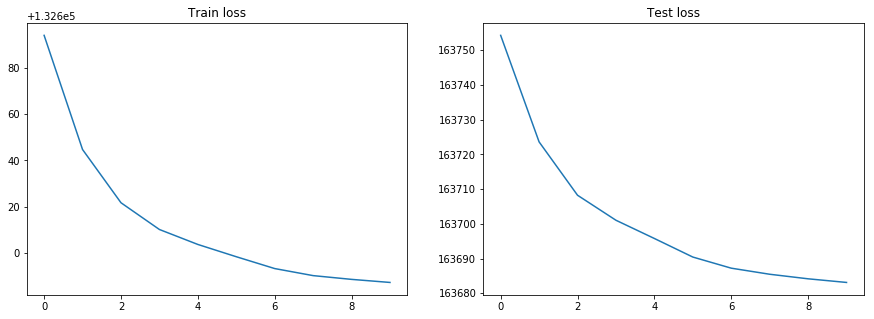

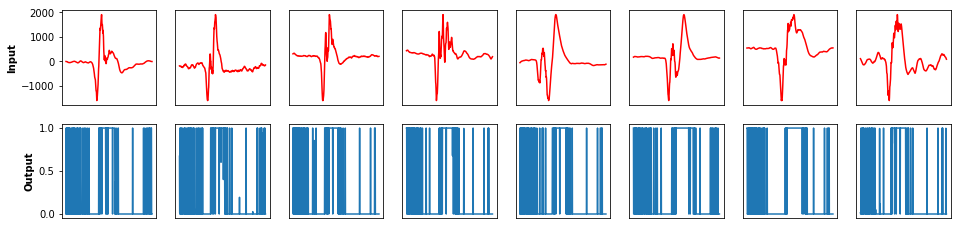

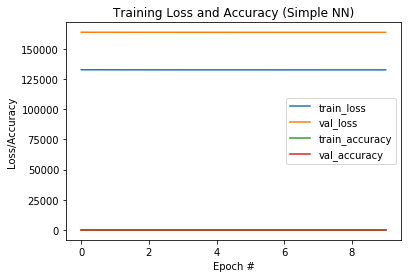

In [108]:
print(decoded_stocks.shape)
print(history.history.keys())
plot_history(history)

plot_examples(x_test_simple, decoded_stocks)

network_evaluation(history, epochs, batch_size)

In [ ]:
# выводим веса на экран
'''for layer in autoencoder.layers:
    weights = layer.get_weights()
    print(weights)'''

(158, 64)


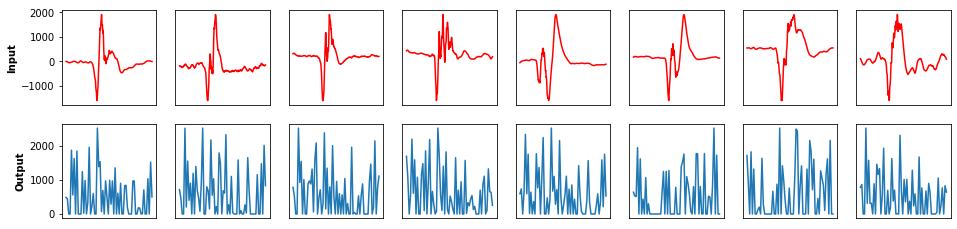

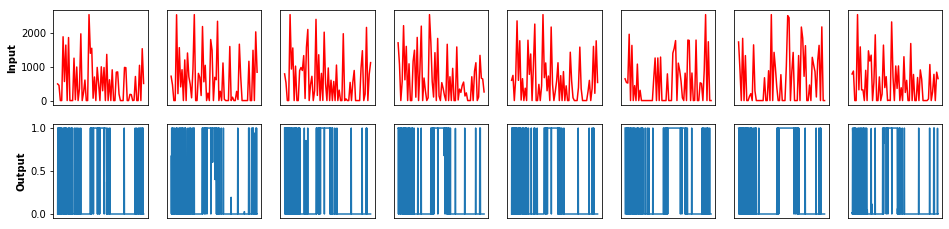

In [109]:
encoded_signals = encoder.predict(x_test_simple)
decoded_signals = decoder.predict(encoded_signals)
print(encoded_signals.shape)

plot_examples(x_test_simple, encoded_signals)
plot_examples(encoded_signals, decoded_signals)

# Deep autoencoder

In [113]:
x_train_deep = np.asarray(train_signals).reshape((len(train_signals), np.prod(np.asarray(train_signals).shape[1:])))
x_test_deep = np.asarray(test_signals).reshape((len(test_signals), np.prod(np.asarray(test_signals).shape[1:])))
x_val_deep = np.asarray(val_signals).reshape((len(val_signals), np.prod(np.asarray(val_signals).shape[1:])))

input_window = Input(shape=(signal_len,))

x = Dense(encoding_dim, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim / 2, activation='relu')(x)

# "decoded" is the lossy reconstruction of the input
x = Dense(encoding_dim, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(signal_len, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim / 2,))

# retrieve the dense layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(x_train_deep, x_train_deep,
                steps_per_epoch=10,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val_deep, x_val_deep),
                validation_steps = 10,
                verbose=1)

decoded_stocks = autoencoder.predict(x_test_deep)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_58:0", shape=(None, 481), dtype=float32) at layer "input_58". The following previous layers were accessed without issue: []

# Plot history (Deep autoencoder)

In [101]:
print(np.asarray(autoencoder.layers[-5]))

(158, 481)
dict_keys(['loss', 'val_loss'])


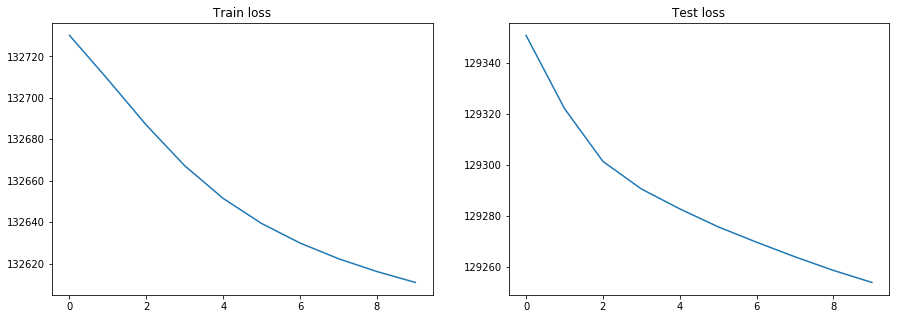

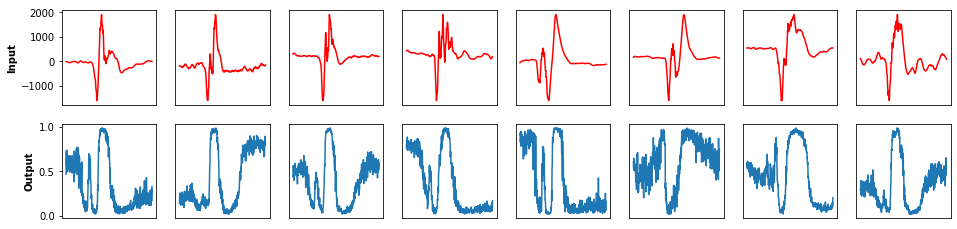

In [112]:
print(decoded_stocks.shape)
print(history.history.keys())

plot_history(history)

plot_examples(x_test_simple, decoded_stocks)

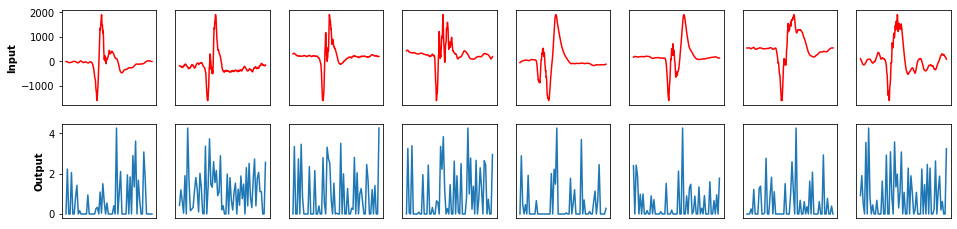

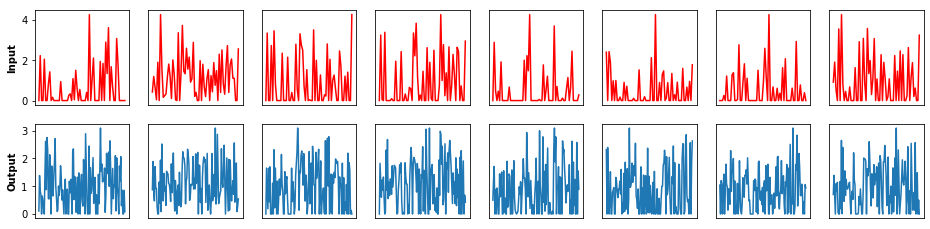

In [105]:
encoded_signals = encoder.predict(x_test_deep)
decoded_signals = decoder.predict(encoded_signals)

plot_examples(x_test_simple, encoded_signals)
plot_examples(encoded_signals, decoded_signals)

# 1D Convolutional autoencoder (Здесь не правил - нужно грамотно настраивать слои)

In [ ]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

# Plot history (1D Convolutional autoencoder)

In [ ]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)